In [225]:
%load_ext autoreload
%autoreload 2

%aimport xclimate

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
from pathlib import Path

import numpy as np
import xarray as xr
import pandas as pd

import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator

import cartopy.crs as ccrs
import cmocean.cm as cmo

import xclimate as xclim

In [161]:
## FHIST PPE

variables = [
    "EFLX_LH_TOT_month_1",
    "TLAI_month_1",
    "PRECC_month_1", "PRECL_month_1",
    "FSDS_month_1", "FSR_month_1", "FLDS_month_1", "FIRE_month_1",  # for net radiation
]

time_slice = slice("1950-01", "2014-12")
year_start = time_slice.start[:4]
year_end = time_slice.stop[:4]
grid = xclim.load_fhist_ppe_grid()

snow_pct_threshold = 100    # maximum allowable percent of snow cover on all months of the average year
nonglc_pct_threshold = 100  # maximum allowable percent of glaciated land for a NON-glaciated gridcell

# fsno = xclim.load_fhist("FSNO_month_1", keep_var_only=True)["FSNO"].sel(time=time_slice).reindex_like(grid, method="nearest", tolerance=1e-3)
# fsno_clim_min = fsno.groupby("time.month").mean().min(dim="month")

# Create masks
nonglc_mask = grid.PCT_GLC <= nonglc_pct_threshold
# snow_mask = fsno_clim_min <= (snow_pct_threshold / 100)
# full_mask = snow_mask & nonglc_mask
full_mask = nonglc_mask

fhist = {}
for v in variables:
    print(f"  {v}")
    name = "_".join(v.split("_")[:-2])
    fhist[v] = xclim.load_fhist(v, keep_var_only=True)[name].sel(time=time_slice).reindex_like(grid, method="nearest", tolerance=1e-3)
    fhist[v] = fhist[v].where(full_mask).chunk({'time': -1, 'lat': -1, 'lon': -1})
    fhist[v].attrs["masks"] = f"gridcell percent glaciated land <= {nonglc_pct_threshold}"

fhist["EFLX_LH_TOT_year_1"] = fhist["EFLX_LH_TOT_month_1"].groupby("time.year").map(lambda x: x.weighted(x.time.dt.days_in_month).mean("time"))

# Monthly net radiation at the surface, + down
#   Rn = (net SW) + (net LW) = (down SW - up SW) - (down LW - up LW)
#   Rn = FSDS - FSR + FLDS - FIRE
print("  RN_month_1")
fhist["RN_month_1"] = fhist["FSDS_month_1"] - fhist["FSR_month_1"] + fhist["FLDS_month_1"] - fhist["FIRE_month_1"]
fhist["RN_month_1"] = fhist["RN_month_1"].rename("RN")
fhist["RN_month_1"].attrs = {
    "long_name": "net radiation at surface [+ down]",
    "description": "FSDS - FSR + FLDS - FIRE",
    "units": "W/m2",
}
fhist.pop("FSDS_month_1")
fhist.pop("FSR_month_1")
fhist.pop("FLDS_month_1")
fhist.pop("FIRE_month_1")

# Monthly PRECT (PRECC + PRECL)
print("  PRECT_month_1")
fhist["PRECT_month_1"] = fhist["PRECC_month_1"] + fhist["PRECL_month_1"]
fhist["PRECT_month_1"].attrs["long_name"] = "total monthly precipitation rate (PRECC + PRECL)"
fhist.pop("PRECC_month_1")
fhist.pop("PRECL_month_1")

# Monthly precipitation rate in energy units
print("  EPRECT_month_1")
fhist["EPRECT_month_1"] = fhist["PRECT_month_1"] * 1000 * 2.5e6
fhist["EPRECT_month_1"] = xr.where(fhist["EPRECT_month_1"] < 1e-3, 1e-3, fhist["EPRECT_month_1"])
fhist["EPRECT_month_1"].attrs = {
    "long_name": f"{fhist['PRECT_month_1'].attrs['long_name']} in energy units",
    "units": "W/m2"
}
fhist.pop('PRECT_month_1')

# Compute climatology
for name in ["TLAI", "RN", "EPRECT"]:
    fhist[f"{name}_clim_1"] = fhist[f"{name}_month_1"].sel(time=time_slice).weighted(fhist[f"{name}_month_1"].time.dt.days_in_month).mean("time")
fhist.pop('RN_month_1')
fhist.pop('EPRECT_month_1')

# Climatological aridity index (AI = PET / P = RN / EPRECT)
print("  AI_clim_1")
fhist["AI_clim_1"] = fhist["RN_clim_1"] / fhist["EPRECT_clim_1"]
fhist["AI_clim_1"] = fhist["AI_clim_1"].rename("AI")
fhist["AI_clim_1"].attrs = {
    "long_name": "aridity index PET/P, higher is more arid",
    "description": "Rn / (Lv * P), filtered P = max(P, 0.001) [W/m2]",
    "time_mean": f"{time_slice.start} to {time_slice.stop}"
}

fhist['AI_clim_1'] = fhist['AI_clim_1'].compute()
fhist['TLAI_clim_1'] = fhist['TLAI_clim_1'].compute()

  EFLX_LH_TOT_month_1
  TLAI_month_1
  PRECC_month_1
  PRECL_month_1
  FSDS_month_1
  FSR_month_1
  FLDS_month_1
  FIRE_month_1
  RN_month_1
  PRECT_month_1
  EPRECT_month_1
  AI_clim_1


In [4]:
## CESM2 LE

variables_lens = [
    "EFLX_LH_TOT",
    "TLAI",
]

grid_lens = xclim.load_cesm2le_grid()
nonglc_mask_lens = grid_lens.PCT_GLC <= nonglc_pct_threshold

lens = {}
for v in variables_lens:
    print(f"  {v}")
    vv = f"{v}_month_1"
    lens[vv] = xclim.load_cesm2le(v, "lnd", "month_1", "h0", keep_var_only=True).sel(time=time_slice)[v].reindex_like(grid_lens, method="nearest", tolerance=1e-3)
    lens[vv] = lens[vv].where(nonglc_mask_lens).chunk({'time': -1, 'lat': -1, 'lon': -1})
    lens[vv].attrs["masks"] = f"gridcell percent glaciated land <= {nonglc_pct_threshold}"

  EFLX_LH_TOT
  TLAI


In [5]:
## ILAMB


ilamb_gm = {"hfls": {}, "lai": {}}

# Load preprocessed ET
indir = Path("/glade/work/bbuchovecky/CPL_PPE_CO2/select_parameters/ILAMB_data/processed")
for f in indir.glob("global_mean/*.nc"):
    key = f.stem.split("_")[3]
    var = f.stem.split("_")[0].lower()
    ilamb_gm[var][key] = xr.open_dataset(f)[var+"_"+key]

In [6]:
## CLM6 PPE

varname = "EFLX_LH_TOT"

# Load parameter settings key
clm6_key = pd.read_csv("/glade/campaign/cgd/tss/projects/PPE/ctsm6_oaat/ctsm6_oaat_key.csv")

# Load postprocessed timeseries dataset
in_file = Path("/glade/campaign/cgd/tss/projects/PPE/ctsm6_oaat/postp/ctsm6_oaat_postp_timeseries_1901-2023.nc")
clm6_ts = xr.open_dataset(in_file).sel(year=slice(int(time_slice.start[:4]), int(time_slice.stop[:4])))

# Append key to ds
clm6_ts = clm6_ts.assign_coords(
    key=("member", clm6_key["key"].values),
    param=("member", clm6_key["param"].values),
    minmax=("member", clm6_key["minmax"].values)
)
clm6_ts = clm6_ts.set_index(ens=["param", "minmax", "key"], append=True)
clm6_et_ts = clm6_ts.EFLX_LH_TOT_global_mean

In [7]:
v = "EFLX_LH_TOT_month_1"
start_yr = 1995
stop_yr = 2014

fhist_et_ts = fhist[v].weighted(grid.LANDAREA).mean(dim=["lat", "lon"]).groupby("time.year").mean().persist()
fhist_et_tm = fhist_et_ts.sel(year=slice(start_yr, stop_yr)).mean(dim="year").persist()

lens_et_ts = lens[v].weighted(grid_lens.LANDAREA).mean(dim=["lat", "lon"]).groupby("time.year").mean().persist()
lens_et_tm = lens_et_ts.sel(year=slice(start_yr, stop_yr)).mean(dim="year").persist()

# clm6_et_ts
clm6_et_tm = clm6_et_ts.sel(year=slice(start_yr, stop_yr)).mean(dim="year").persist()

In [45]:
## Set mpl.rcParams

mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

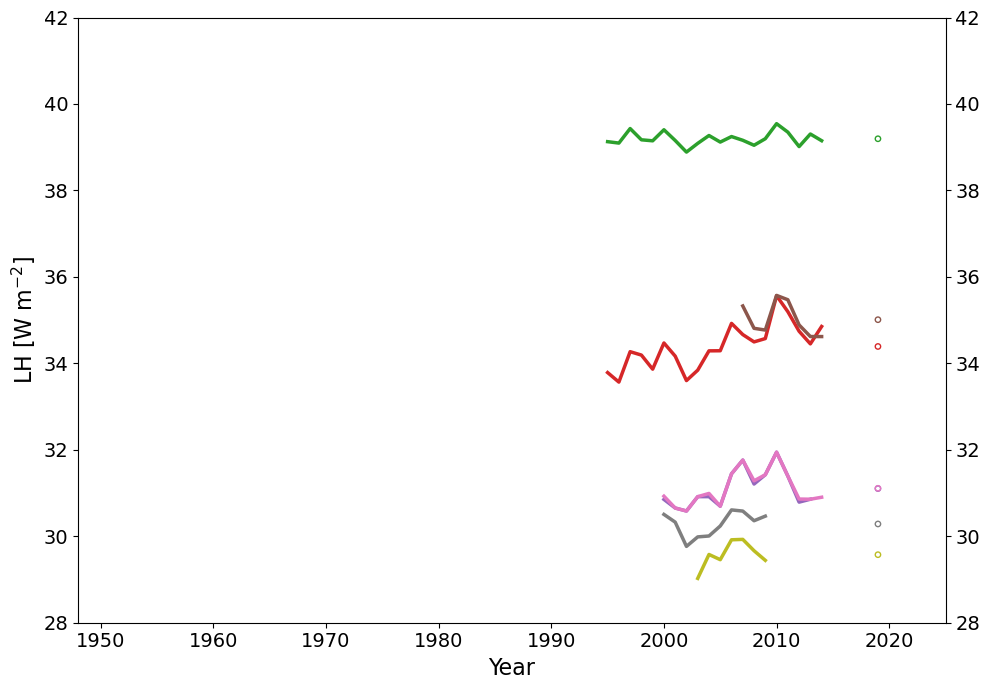

In [93]:
name = "LH"
units = "W m$^{-2}$"

fig, ax = plt.subplots(1, 1, figsize=(10, 7))


# Plot ILAMB datasets
cs_ilamb = list(mcolors.TABLEAU_COLORS.keys())[2:]
for i, (key, da) in enumerate(ilamb_gm['hfls'].items()):
    da_trunc = da.sel(year=slice(start_yr, stop_yr))
    ax.plot(da_trunc.year, da_trunc, c=cs_ilamb[i], ls="-", lw=2.5, label=key, zorder=100)
    ax.scatter(stop_yr + 5, da_trunc.mean(dim="year"), marker="o", s=15, edgecolor=cs_ilamb[i], facecolor="none")


# # Plot the timeseries for CLM6 PPE
# for i, e in enumerate(clm6_et_ts.ens):
#     label = None
#     if i == 0:
#         label = f"CLM6 PPE (n={len(clm6_et_ts.ens)})"
#     clm6_et_ts.sel(ens=e).plot(ax=ax, color="silver", alpha=0.5, lw=1, label=label, _labels=False, zorder=0)

# # Plot the violin plot for CLM6 PPE
# vp = xclim.plot._create_violin_plot(
#     ax,
#     clm6_et_tm,
#     stop_yr + 2,
#     "silver",
#     "silver",
# )

# # Highlight the CLM6 PPE default
# clm6_et_ts.sel(param="default", minmax="max").plot(ax=ax, color="darkgray", lw=2, ls="-", alpha=0.7, label="CLM6 PPE 0", _labels=False, zorder=1)
# ax.scatter(
#     stop_yr + 5,
#     clm6_et_tm.sel(param="default", minmax="max"),
#     s=15,
#     marker="o",
#     color="darkgray",
# )


# # Plot FHIST PPE
# das = [fhist_et_ts]
# das_violin = [fhist_et_tm]
# das_labels = ["FHIST PPE"]
# _, ax = xclim.plot.plot_ensemble_line(
#     das=das,
#     das_violin=das_violin,
#     das_labels=das_labels,
#     ylabel=f"{name} [{units}]",
#     plot_dim="year",
#     xlabel="Year",
#     highlight_member=[0],
#     colors=["tab:blue"],
#     violin_xrange=None,
#     violin_settings={"x": stop_yr + 2},
#     add_legend=False,
#     ax=ax,
# )


# # Plot LENS2
# das = [lens_et_ts]
# das_violin = [lens_et_tm]
# das_labels = ["LENS2"]
# _, ax = xclim.plot.plot_ensemble_line(
#     das=das,
#     das_violin=das_violin,
#     das_labels=das_labels,
#     ylabel=f"{name} [{units}]",
#     plot_dim="year",
#     xlabel="Year",
#     highlight_member=[None],
#     colors=["tab:orange"],
#     violin_xrange=None,
#     violin_settings={"x": stop_yr + 2},
#     add_legend=False,
#     ax=ax,
# )


# Add a legend
# ax.legend(loc="lower left", ncols=2, fontsize=11, fancybox=False, frameon=False)

ax.set_xlabel("Year")
ax.set_ylabel(f"{name} [{units}]")
ax.yaxis.set_ticks_position("both")
ax.tick_params(axis="y", labelright=True)
ax.set_xlim(1948, 2025)
ax.set_ylim(28, 42)

# Save figure
# fig.suptitle(f"Global Land Mean, Annual Mean Timeseries, {name} [{units}]", x=0.075, y=0.96, ha="left")
plt.tight_layout()
plt.savefig(f"fig/lmwg/a.global.lnd.{name}.ILAMB.png", dpi=300, bbox_inches="tight")
# plt.close(fig)

In [76]:
v = "TLAI_month_1"
start_yr = 1995
stop_yr = 2014

fhist_lai_ts = fhist[v].weighted(grid.LANDAREA).mean(dim=["lat", "lon"]).groupby("time.year").mean().persist()
fhist_lai_tm = fhist_lai_ts.sel(year=slice(start_yr, stop_yr)).mean(dim="year").persist()

lens_lai_ts = lens[v].weighted(grid_lens.LANDAREA).mean(dim=["lat", "lon"]).groupby("time.year").mean().persist()
lens_lai_tm = lens_lai_ts.sel(year=slice(start_yr, stop_yr)).mean(dim="year").persist()

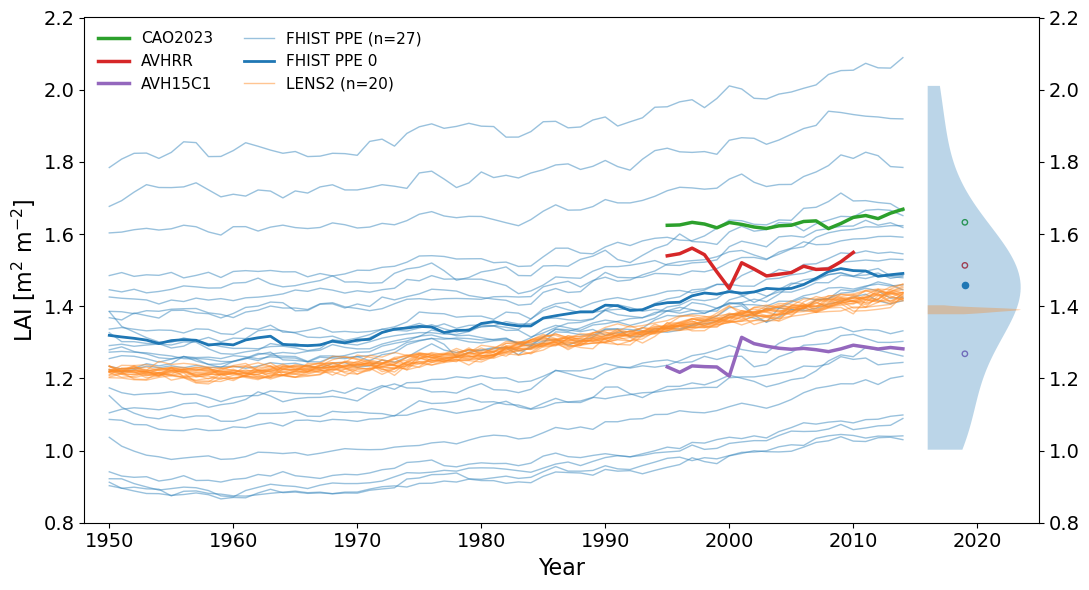

In [102]:
name = "LAI"
units = "m$^2$ m$^{-2}$"

fig, ax = plt.subplots(1, 1, figsize=(11, 6))


# Plot ILAMB datasets
cs_ilamb = list(mcolors.TABLEAU_COLORS.keys())[2:]
for i, (key, da) in enumerate(ilamb_gm['lai'].items()):
    da_trunc = da.sel(year=slice(start_yr, stop_yr))
    ax.plot(da_trunc.year, da_trunc, c=cs_ilamb[i], ls="-", lw=2.5, label=key, zorder=100)
    ax.scatter(stop_yr + 5, da_trunc.mean(dim="year"), marker="o", s=15, edgecolor=cs_ilamb[i], facecolor="none")


# Plot FHIST PPE
das = [fhist_lai_ts]
das_violin = [fhist_lai_tm]
das_labels = ["FHIST PPE"]
_, ax = xclim.plot.plot_ensemble_line(
    das=das,
    das_violin=das_violin,
    das_labels=das_labels,
    ylabel=f"{name} [{units}]",
    plot_dim="year",
    xlabel="Year",
    highlight_member=[0],
    colors=["tab:blue"],
    violin_xrange=None,
    violin_settings={"x": stop_yr + 2},
    add_legend=False,
    ax=ax,
)


# Plot LENS2
das = [lens_lai_ts]
das_violin = [lens_lai_tm]
das_labels = ["LENS2"]
_, ax = xclim.plot.plot_ensemble_line(
    das=das,
    das_violin=das_violin,
    das_labels=das_labels,
    ylabel=f"{name} [{units}]",
    plot_dim="year",
    xlabel="Year",
    highlight_member=[None],
    colors=["tab:orange"],
    violin_xrange=None,
    violin_settings={"x": stop_yr + 2},
    add_legend=False,
    ax=ax,
)


# Add a legend
ax.legend(loc="upper left", ncols=2, fontsize=11, fancybox=False, frameon=False)

ax.set_xlabel("Year")
ax.set_ylabel(f"{name} [{units}]")
ax.yaxis.set_ticks_position("both")
ax.tick_params(axis="y", labelright=True)
ax.set_xlim(1948, 2025)
ax.set_ylim(0.8, 2.2)

# Save figure
# fig.suptitle(f"Global Land Mean, Annual Mean Timeseries, {name} [{units}]", x=0.075, y=0.96, ha="left")
plt.tight_layout()
plt.savefig(f"fig/lmwg/a.global.lnd.{name}.ILAMB-FHIST-LENS2-legend.png", dpi=300, bbox_inches="tight")
# plt.close(fig)

In [9]:
nb = 15
mask_type = "mask_glc80_snow80"
qbin_variables = [
    "AI_clim_1",
    "TLAI_month_1",
    "TLAI_year_1",
    "TLAI_clim_1",
    "TOTANNPRECT_year_1",
    "TSA_year_1",
]
rootdir = Path("/glade/work/bbuchovecky/et_controls/proc/qbin")

grid = xclim.load_fhist_ppe_grid()

qbin = {}
for v in qbin_variables:
    if "cor" in v:
        t = "1950-2014"
    else:
        t = "1995-2014"

    qbin[v] = xr.open_mfdataset(
        list((rootdir / mask_type / v).glob(f"qbin{nb}.{t}.TIMEagg.{v}.*.nc")),
        combine="nested",
        concat_dim="member",
    ).sortby("member").reindex_like(grid, method="nearest", tolerance=1e-3)

In [83]:
example_member = 0

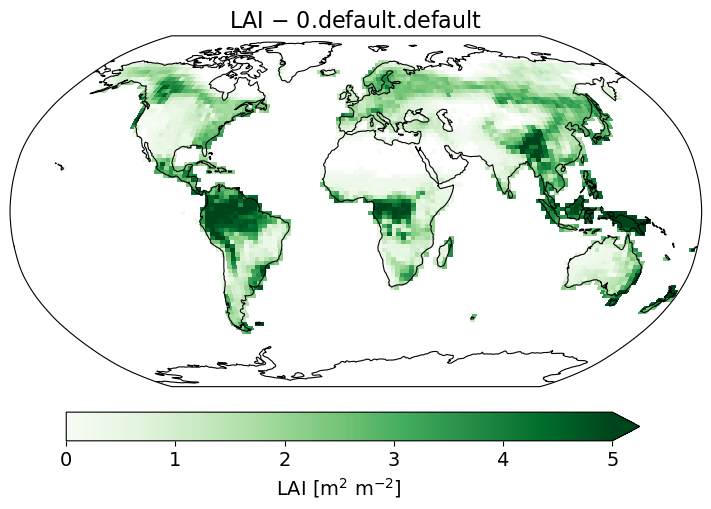

In [185]:
fig, ax = plt.subplots(figsize=(7, 6), subplot_kw={'projection': ccrs.Robinson()}, layout='constrained')

# Create a custom colormap starting from white
greens_cmap = plt.get_cmap('Greens')
colors = greens_cmap(np.linspace(0, 1, 256))
colors[0] = [1, 1, 1, 1]  # Set first color to white (RGBA)
white_greens = mcolors.LinearSegmentedColormap.from_list('WhiteGreens', colors)

fhist["TLAI_clim_1"].sel(member=example_member).plot(
    ax=ax,
    cmap=white_greens,
    vmin=0, vmax=5,
    extend='max',
    transform=ccrs.PlateCarree(),
    cbar_kwargs={
        'label': 'LAI [m$^2$ m$^{-2}$]',
        'fraction': 0.06,
        'orientation': 'horizontal',
    },
)

ax.coastlines(lw=0.8, color="k")
ax.set_title('LAI $-$ '+xclim.ppe.get_member_name(example_member), fontsize=16)

fig.savefig(f'fig/lmwg/LAI_clim_1.{example_member}.png', bbox_inches='tight', dpi=300)

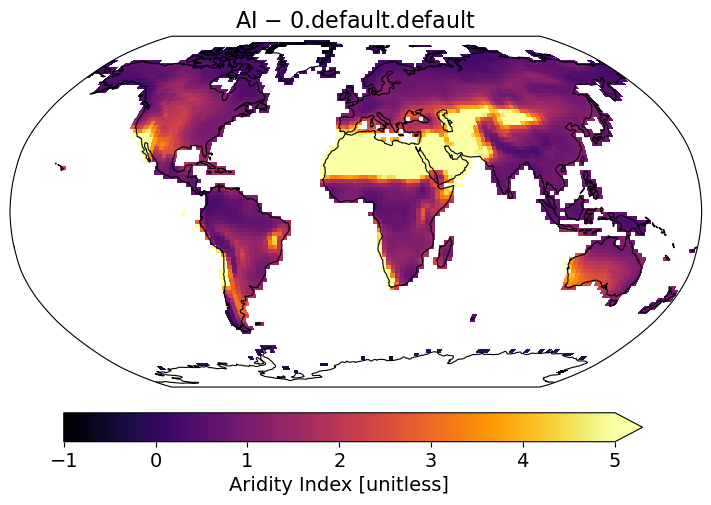

In [199]:
fig, ax = plt.subplots(figsize=(7, 6), subplot_kw={'projection': ccrs.Robinson()}, layout='constrained')

# Create a custom colormap starting from white
purples_cmap = plt.get_cmap('Purples')
colors = purples_cmap(np.linspace(0, 1, 256))
colors[0] = [1, 1, 1, 1]  # Set first color to white (RGBA)
white_purples = mcolors.LinearSegmentedColormap.from_list('WhitePurples', colors)

fhist["AI_clim_1"].sel(member=example_member).where(grid.PCT_GLC < 80).plot(
    ax=ax,
    cmap='inferno',
    vmin=-1, vmax=5,
    extend='max',
    transform=ccrs.PlateCarree(),
    cbar_kwargs={
        'label': 'Aridity Index [unitless]',
        'fraction': 0.06,
        'orientation': 'horizontal',
    },
)

ax.coastlines(lw=0.8, color="k")
ax.set_title('AI $-$ '+xclim.ppe.get_member_name(example_member), fontsize=16)

fig.savefig(f'fig/lmwg/AI_clim_1.{example_member}.png', bbox_inches='tight', dpi=300)

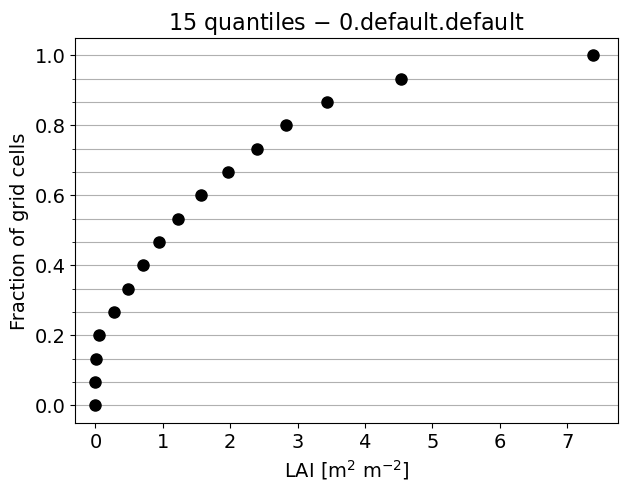

In [122]:
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(
    qbin["TLAI_clim_1"].x_edge.sel(member=example_member),
    qbin["TLAI_clim_1"].qx,
    marker='o',
    lw=0,
    markersize=8,
    color='k',
    label=f'quantile bin edges $(n={nb})$'
)

ax.yaxis.set_minor_locator(FixedLocator(qbin["TLAI_clim_1"].qx))
ax.grid(which='both', axis='y')
ax.set_xlabel("LAI [m$^2$ m$^{-2}$]")
ax.set_ylabel("Fraction of grid cells")
ax.set_xlim(-0.3, None)
ax.set_title(f'{nb} quantiles $-$ '+xclim.ppe.get_member_name(example_member), fontsize=16)

fig.savefig(f'fig/lmwg/qbin{nb}.x_edge.LAI_clim_1.{example_member}.png', bbox_inches='tight', dpi=300)

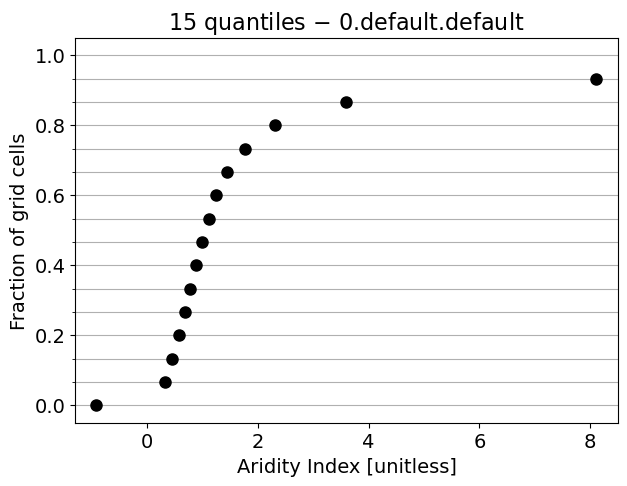

In [123]:
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(
    qbin["AI_clim_1"].x_edge.sel(member=example_member),
    qbin["AI_clim_1"].qx,
    marker='o',
    lw=0,
    markersize=8,
    color='k',
    label=f'quantile bin edges $(n={nb})$'
)

ax.yaxis.set_minor_locator(FixedLocator(qbin["AI_clim_1"].qx))
ax.grid(which='both', axis='y')
ax.set_xlabel("Aridity Index [unitless]")
ax.set_ylabel("Fraction of grid cells")
ax.set_xlim(-1.3, 8.5)
ax.set_title(f'{nb} quantiles $-$ '+xclim.ppe.get_member_name(example_member), fontsize=16)

fig.savefig(f'fig/lmwg/qbin{nb}.x_edge.AI_clim_1.{example_member}.png', bbox_inches='tight', dpi=300)

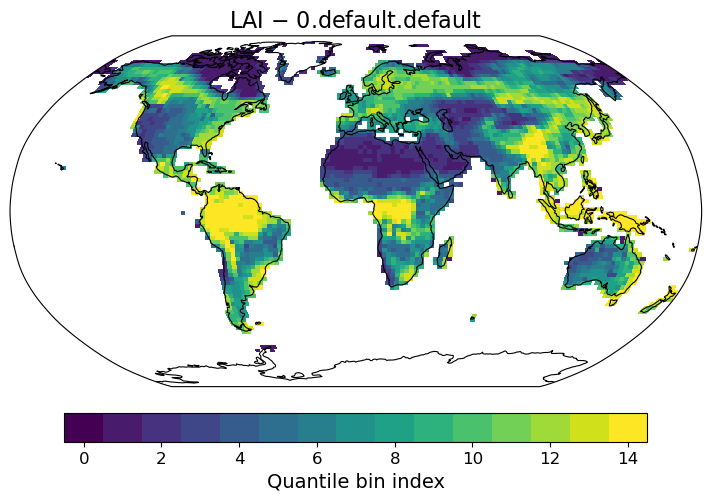

In [201]:
fig, ax = plt.subplots(figsize=(7, 6), subplot_kw={'projection': ccrs.Robinson()}, layout='constrained')

cmap = plt.get_cmap('viridis', nb)
bounds = np.arange(-0.5, nb + 0.5, 1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)
qbin["TLAI_clim_1"].x_bin.sel(member=example_member).plot(
    ax=ax,
    cmap=cmap,
    norm=norm,
    transform=ccrs.PlateCarree(),
    cbar_kwargs={
        'fraction': 0.06,
        'orientation': 'horizontal',
        'ticks': [],
        "drawedges": False,  # remove segment boundaries
    },
)

cbar = ax.collections[0].colorbar
cbar.ax.minorticks_off()
cbar.set_label('Quantile bin index', fontsize=14)
cbar.set_ticks(np.arange(0, 15, 2))
cbar.set_ticklabels(np.arange(0, 15, 2), fontsize=12)

ax.coastlines(lw=0.8, color="k")
ax.set_title('LAI $-$ '+xclim.ppe.get_member_name(example_member), fontsize=16)

fig.savefig(f'fig/lmwg/qbin{nb}.x_bin.LAI_clim_1.{example_member}.svg', bbox_inches='tight', dpi=300)

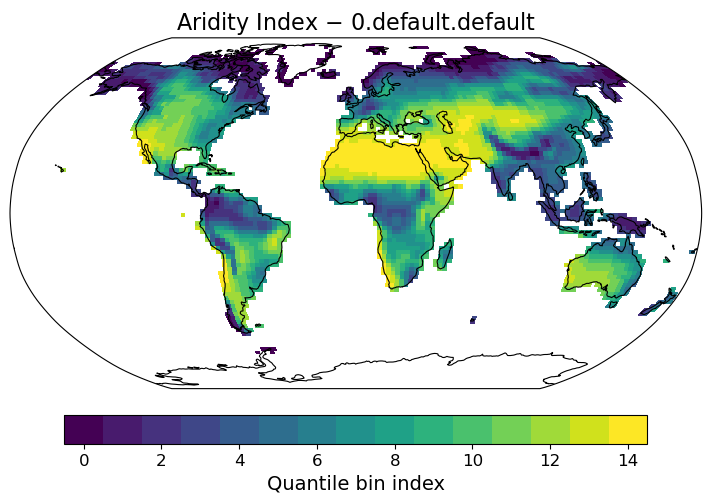

In [117]:
fig, ax = plt.subplots(figsize=(7, 6), subplot_kw={'projection': ccrs.Robinson()}, layout='constrained')

cmap = plt.get_cmap('viridis', nb)
bounds = np.arange(-0.5, nb + 0.5, 1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)
qbin["AI_clim_1"].x_bin.sel(member=example_member).plot(
    ax=ax,
    cmap=cmap,
    norm=norm,
    transform=ccrs.PlateCarree(),
    cbar_kwargs={
        'fraction': 0.06,
        'orientation': 'horizontal',
        'ticks': [],
        "drawedges": False,  # remove segment boundaries
    },
)

cbar = ax.collections[0].colorbar
cbar.ax.minorticks_off()
cbar.set_label('Quantile bin index', fontsize=14)
cbar.set_ticks(np.arange(0, 15, 2))
cbar.set_ticklabels(np.arange(0, 15, 2), fontsize=12)

ax.coastlines(lw=0.8, color="k")
ax.set_title("Aridity Index $-$ " + xclim.ppe.get_member_name(example_member), fontsize=16)

fig.savefig(f'fig/lmwg/qbin{nb}.x_bin.AI_clim_1.{example_member}.png', bbox_inches='tight', dpi=300)

Text(0.5, 1.0, 'Example bins $-$ 0.default.default')

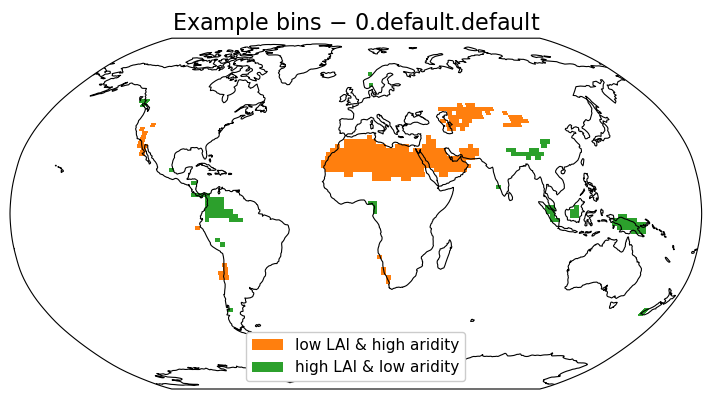

In [ ]:
fig, ax = plt.subplots(figsize=(7, 6), subplot_kw={'projection': ccrs.Robinson()}, layout='constrained')

mask = xr.where(
    (
        (qbin["TLAI_clim_1"].x_bin.sel(member=example_member) <= 2) & \
        (qbin["AI_clim_1"].x_bin.sel(member=example_member) >= 12)
        # (qbin["TLAI_clim_1"].x_bin.sel(member=example_member) <= 4) & \
        # (qbin["AI_clim_1"].x_bin.sel(member=example_member) >= 9) & \
        # (qbin["AI_clim_1"].x_bin.sel(member=example_member) <= 12)
    ),
    1, np.nan,
).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
    cmap=mcolors.ListedColormap(['tab:orange']),
    vmin=0.5,
    vmax=1.5,
)

mask = xr.where(
    (
        (qbin["TLAI_clim_1"].x_bin.sel(member=example_member) >= 12) & \
        (qbin["AI_clim_1"].x_bin.sel(member=example_member) <= 2)
    ),
    1, np.nan,
).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
    cmap=mcolors.ListedColormap(['tab:green']),
    vmin=0.5,
    vmax=1.5,
)

# Create custom legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='tab:orange', label='low LAI & high aridity'),
    Patch(facecolor='tab:green', label='high LAI & low aridity')
]
ax.legend(handles=legend_elements, loc='lower center', fontsize=11, frameon=True, fancybox=True, framealpha=1)

ax.coastlines(lw=0.8, color="k")
ax.set_title('Example bins $-$ '+xclim.ppe.get_member_name(example_member), fontsize=16)

# fig.savefig(f'fig/lmwg/qbin{nb}.bin_example.{example_member}.png', bbox_inches='tight', dpi=300)

In [206]:
cmap = plt.get_cmap('magma')
cmap = cmap(np.linspace(0.2, 1.0, cmap.N))
cmap = mcolors.ListedColormap(cmap)# Store metadata (d = delta, a = absolute)
z_type = "d"
x_type = "a"
y_type = "a"

alpha = 0.05
n_min = 50

In [219]:
qbin_time_slice = slice('1995-01', '2014-12')
qbin_year_slice = slice(1995, 2014)

In [220]:
bs_mn, sg_mn = xclim.full_bin_stats(
    z=fhist["EFLX_LH_TOT_month_1"].sel(time=qbin_time_slice, member=slice(1, None)) - fhist["EFLX_LH_TOT_month_1"].sel(time=qbin_time_slice, member=0),
    x_bin=qbin[f"AI_clim_1"].x_bin.sel(member=slice(1, None)),
    y_bin=qbin[f"TLAI_month_1"].x_bin.sel(time=qbin_time_slice, member=slice(1, None)),
    xnb=nb,
    ynb=nb,
    z_time_coord='time',
    alpha=alpha,
    n_min=n_min,
)

bs_mn = bs_mn.compute()
sg_mn = sg_mn.compute()

In [222]:
bs_yr, sg_yr = xclim.full_bin_stats(
    z=fhist["EFLX_LH_TOT_year_1"].sel(year=qbin_year_slice, member=slice(1, None)) - fhist["EFLX_LH_TOT_year_1"].sel(year=qbin_year_slice, member=0),
    x_bin=qbin[f"AI_clim_1"].x_bin.sel(member=slice(1, None)),
    y_bin=qbin[f"TLAI_year_1"].x_bin.sel(year=qbin_year_slice, member=slice(1, None)),
    xnb=nb,
    ynb=nb,
    z_time_coord='year',
    alpha=alpha,
    n_min=n_min,
)

bs_yr = bs_yr.compute()
sg_yr = sg_yr.compute()

In [223]:
## Set mpl.rcParams

mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

In [276]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.patches import Patch
from matplotlib.patches import Circle
from matplotlib.patches import Rectangle


def plot_fhist_binned_mean_single(
    bm,
    jh,
    nb,
    member,
    z_var,
    x_var,
    y_var,
    cmap,
    vmin,
    vmax,
    vabs=None,
    signif=None,
    add_circles=True,
    figsize=(5, 5),
):
    """
    Create a single-panel binned mean plot for a specific FHIST ensemble member.

    Generates a single subplot showing binned mean values for the specified ensemble
    member, with optional overlaid circles representing sample sizes.

    Parameters
    ----------
    bm : xarray.DataArray
        Binned mean values with dimensions including 'member', 'ibx', and 'iby'.
    jh : xarray.DataArray
        Sample count (joint histogram) data with dimensions including 'member', 'ibx', and 'iby'.
    nb : int
        Number of bins along each axis. Used to set tick positions and labels.
    member : str or int
        Specific member to plot.
    z_var : str
        Name of the variable being shaded. Used for labeling.
    x_var : str
        Name of the variable on the x-axis. Used for labeling.
    y_var : str
        Name of the variable on the y-axis. Used for labeling.
    cmap : str
        Colormap for the plot.
    vmin, vmax : float
        Define the data range that the colormap covers.
    vabs : float, optional
        If provided, centers the colormap range around zero and sets vmin=-vabs, vmax=vabs.
    signif : dict, optional
        Dictionary containing the keys 'alpha' and 'n_min'. If provided, adds annotation under the
        colorbar describing statistical significance.
    add_circles : bool, optional
        Add circles with radii that correspond to the bin sample size.
    figsize : tuple, optional
        Figure size (width, height) in inches.

    Returns
    -------
    matplotlib.figure.Figure
        Figure object containing the single subplot with colorbar.
    matplotlib.axes.Axes
        Axes object for the subplot.
    """
    bm = bm.compute()
    jh = jh.compute()

    if vabs is not None:
        vmin = -vabs
        vmax = vabs

    scaling_power = 0.4
    ref_count = round(jh.max().values.item() / 1e2, 0) * 1e2
    radius_scalar = 0.4
    lw_scalar = 0.5
    line_alpha = 0.5

    fig, ax = plt.subplots(
        figsize=figsize,
        subplot_kw=dict(box_aspect=1),
        constrained_layout=True,
        dpi=100,
    )

    # Plot the binned mean
    pcm = ax.pcolormesh(
        bm.sel(member=member), shading="auto", cmap=cmap, vmin=vmin, vmax=vmax
    )

    if add_circles:
        m_jh = jh.sel(member=member).T
        for ii in range(len(jh.ibx)):
            for jj in range(len(jh.iby)):
                count = m_jh.values[ii, jj]
                if count > 0:
                    radius = radius_scalar * ((count / ref_count) ** scaling_power)
                    lw = lw_scalar + ((count / ref_count) ** scaling_power)
                    circle = Circle(
                        (ii + 0.5, jj + 0.5),
                        radius,
                        fill=False,
                        edgecolor="black",
                        linewidth=lw,
                        alpha=line_alpha,
                    )
                    ax.add_patch(circle)
                    # circle = Rectangle(
                    #     (ii + 0.5 - radius, jj + 0.5 - radius),
                    #     2*radius, 2*radius,
                    #     fill=False,
                    #     edgecolor="black",
                    #     linewidth=lw,
                    #     alpha=line_alpha,
                    # )
                    # ax.add_patch(circle)


    ax.set_title(
        xclim.ppe.get_member_name(member),
        color=xclim.ppe.get_member_cat_color(member),
        fontsize=16,
        fontweight="bold",
    )
    ax.set_xlim(0, len(bm.ibx))
    ax.set_ylim(0, len(bm.iby))

    ax.set_yticks(np.arange(nb) + 0.5)
    ax.set_xticks(np.arange(nb) + 0.5)
    ax.tick_params(length=0)

    ticklabels = np.full((nb), "", dtype=object)
    ticklabels[0] = "low"
    ticklabels[-1] = "high"

    ax.set_yticklabels(ticklabels, rotation=35, ha="right", va="center")
    ax.set_xticklabels(ticklabels, rotation=35, ha="center", va="top")

    ax.set_ylabel(f"{y_var}", fontsize=12)
    ax.set_xlabel(f"{x_var}", fontsize=12)

    # Add colorbar
    if vmin == 0:
        extend = "max"
    else:
        extend = "both"
    cbar = fig.colorbar(
        pcm,
        ax=ax,
        orientation="vertical",
        extend=extend,
        fraction=0.05,
        shrink=0.9,
        pad=0.05,
    )
    cbar.set_label(z_var, fontsize=12)

    # Draw the figure to apply and fix layout
    fig.canvas.draw()

    # Get colorbar position
    cbar_pos = cbar.ax.get_position()

    if signif is not None:
        # Add text below legend for alpha and n_min parameters
        alpha = signif.get('alpha', 'alpha')
        n_min = signif.get('n_min', 'n_min')
        fig.text(
            (cbar_pos.x0 + cbar_pos.x1) / 2,
            cbar_pos.y0 - 0.05,
            f"$Significance$: $two$-$sided$ $t$-$test$ $\\alpha = {alpha}$, $n \\geq {n_min}$",
            ha="center",
            va="top",
            fontsize=10,
            transform=fig.transFigure,
        )

    return fig, ax, cbar

In [307]:
def plot_fhist_binned_mean_multi(
    bm,
    jh,
    nb,
    members,
    z_var,
    x_var,
    y_var,
    cmap,
    vmin,
    vmax,
    vabs=None,
    signif=None,
    add_circles=True,
    ncols=3,
    figsize=None,
):
    """
    Create a multi-panel binned mean plot for specified FHIST ensemble members.

    Generates a figure with subplots showing binned mean values for the specified
    ensemble members, with optional overlaid circles representing sample sizes.

    Parameters
    ----------
    bm : xarray.DataArray
        Binned mean values with dimensions including 'member', 'ibx', and 'iby'.
    jh : xarray.DataArray
        Sample count (joint histogram) data with dimensions including 'member', 'ibx', and 'iby'.
    nb : int
        Number of bins along each axis. Used to set tick positions and labels.
    members : list
        List of specific members to plot.
    z_var : str
        Name of the variable being shaded. Used for labeling.
    x_var : str
        Name of the variable on the x-axis. Used for labeling.
    y_var : str
        Name of the variable on the y-axis. Used for labeling.
    cmap : str
        Colormap for the plot.
    vmin, vmax : float
        Define the data range that the colormap covers.
    vabs : float, optional
        If provided, centers the colormap range around zero and sets vmin=-vabs, vmax=vabs.
    signif : dict, optional
        Dictionary containing the keys 'alpha' and 'n_min'. If provided, adds annotation under the
        colorbar describing statistical significance.
    add_circles : bool, optional
        Add circles with radii that correspond to the bin sample size.
    ncols : int, optional
        Number of columns in the subplot grid. Default is 3.
    figsize : tuple, optional
        Figure size (width, height) in inches. If None, calculated based on ncols and nrows.

    Returns
    -------
    matplotlib.figure.Figure
        Figure object containing the multi-panel plot with colorbar.
    matplotlib.axes.Axes
        Ndarray of axes objects for each subplot.
    """
    bm = bm.compute()
    jh = jh.compute()

    if vabs is not None:
        vmin = -vabs
        vmax = vabs

    scaling_power = 0.4
    ref_count = round(jh.max().values.item() / 1e2, 0) * 1e2
    radius_scalar = 0.4
    lw_scalar = 0.3
    line_alpha = 0.5

    # Calculate number of rows needed
    nrows = int(np.ceil(len(members) / ncols))

    # Set figure size if not provided
    if figsize is None:
        figsize = (ncols * 4, nrows * 4)

    fig, axs = plt.subplots(
        ncols=ncols,
        nrows=nrows,
        sharex=True,
        sharey=True,
        figsize=figsize,
        subplot_kw=dict(box_aspect=1),
        constrained_layout=True,
        dpi=100,
    )

    # Handle case where only one subplot is created
    if nrows == 1 and ncols == 1:
        axs = np.array([axs])
    elif nrows == 1 or ncols == 1:
        axs = axs.reshape(-1)
    
    ax = axs.flatten()

    pcm = None
    for i, m in enumerate(members):
        pcm = ax[i].pcolormesh(
            bm.sel(member=m), shading="auto", cmap=cmap, vmin=vmin, vmax=vmax
        )

        if add_circles:
            m_jh = jh.sel(member=m).T
            for ii in range(len(jh.ibx)):
                for jj in range(len(jh.iby)):
                    count = m_jh.values[ii, jj]
                    if count > 0:
                        radius = radius_scalar * ((count / ref_count) ** scaling_power)
                        lw = lw_scalar + ((count / ref_count) ** scaling_power)
                        circle = Circle(
                            (ii + 0.5, jj + 0.5),
                            radius,
                            fill=False,
                            edgecolor="black",
                            linewidth=lw,
                            alpha=line_alpha,
                        )
                        ax[i].add_patch(circle)

        ax[i].set_title(
            xclim.ppe.get_member_name(m),
            color=xclim.ppe.get_member_cat_color(m),
            fontsize=14,
            fontweight="bold",
        )
        ax[i].set_xlim(0, len(bm.ibx))
        ax[i].set_ylim(0, len(bm.iby))

        ax[i].set_yticks(np.arange(nb) + 0.5)
        ax[i].set_xticks(np.arange(nb) + 0.5)
        ax[i].tick_params(length=0)

        ticklabels = np.full((nb), "", dtype=object)
        ticklabels[0] = "low"
        ticklabels[-1] = "high"

        ax[i].set_yticklabels(ticklabels, rotation=35, ha="right", va="center")
        ax[i].set_xticklabels(ticklabels, rotation=35, ha="center", va="top")

        if i % ncols == 0:
            ax[i].set_ylabel(f"{y_var}", fontsize=12)
        if i // ncols == nrows - 1:
            ax[i].set_xlabel(f"{x_var}", fontsize=12)

    # Remove empty subplots
    for i in range(len(members), ncols * nrows):
        ax[i].remove()

    return fig, axs

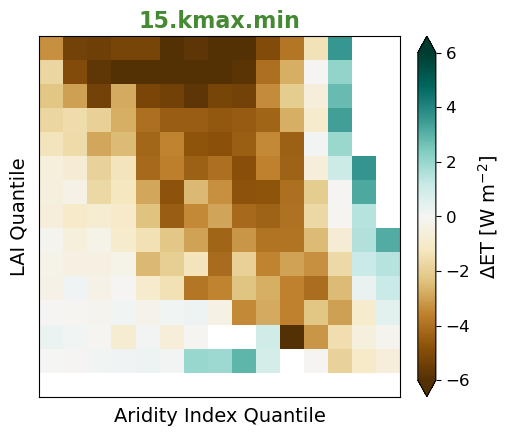

In [342]:
fig, ax, cbar = plot_fhist_binned_mean_single(
    bs_yr.sel(stats_name="mean"), bs_yr.sel(stats_name="n"), nb, 15, "$\\Delta$ET [W m$^{-2}$]", "Aridity Index", "LAI",
    cmap="BrBG", vmin=-6, vmax=6,
    signif=None, #{"alpha": alpha, "n_min": n_min},
    add_circles=False,
)

ax.set_xlabel("Aridity Index Quantile", fontsize=14)
ax.set_ylabel("LAI Quantile", fontsize=14)

ax.tick_params(length=0)
ax.set_xticks(np.arange(15) + 0.5)
ax.set_xticklabels([])
ax.set_yticks(np.arange(15) + 0.5)
ax.set_yticklabels([])

ticklabels = np.full((nb), "", dtype=object)
ticklabels[0] = "low"
ticklabels[-1] = "high"

cbar.set_label("$\\Delta$ET [W m$^{-2}$]", fontsize=14)

In [ ]:
decr_ET_lowLAI_highAI_members = [1, 2, 3, 4 5, 6, 7, 8, 10, 11, 12, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]

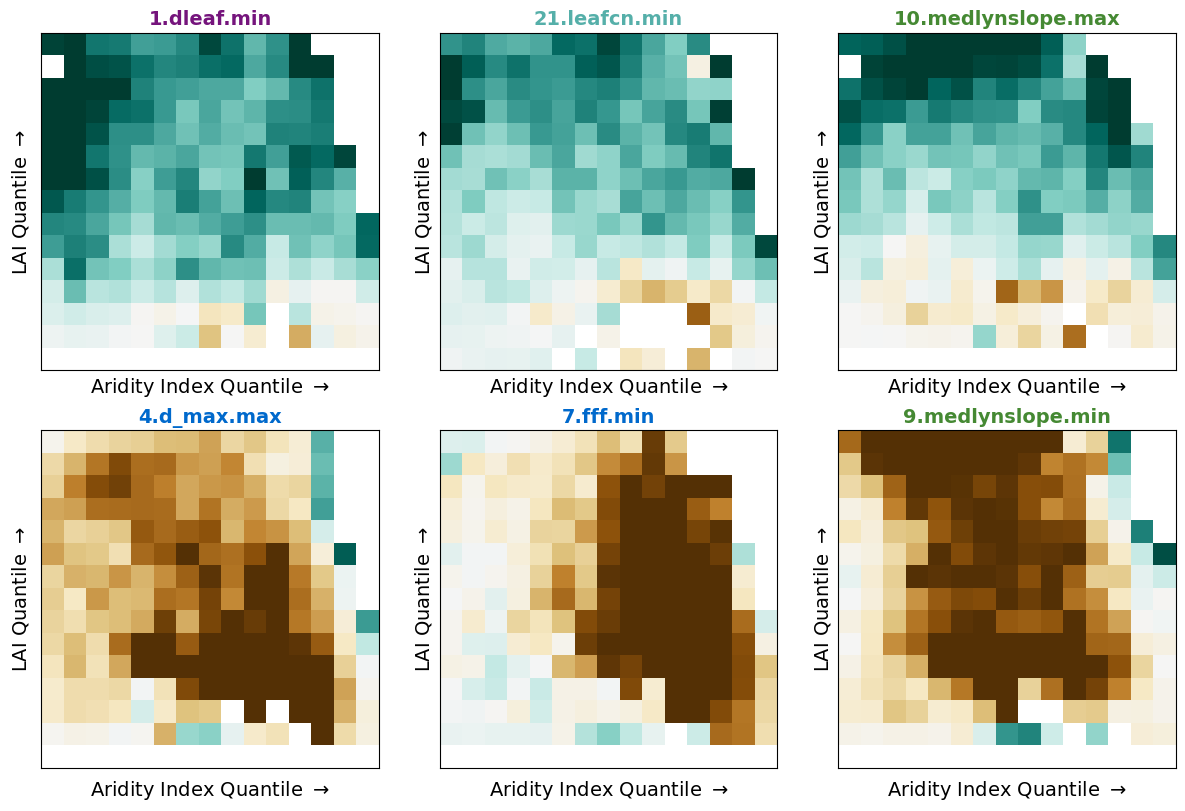

In [333]:
members = [
    1, 21, 10,
    4, 7, 9
]
ncols = 3

fig, axs = plot_fhist_binned_mean_multi(
    bs_yr.sel(stats_name="mean"), bs_yr.sel(stats_name="n"), nb, members, "$\\Delta$ET [W m$^{-2}$]", "Aridity Index Quantile", "LAI Quantile",
    cmap="BrBG", vmin=-6, vmax=6, ncols=ncols,
    signif=None, add_circles=False,
)

ax = axs.flatten()
for i in range(len(members)):
    ax[i].tick_params(length=0)
    ax[i].set_xticks(np.arange(15) + 0.5)
    ax[i].set_xticklabels([])
    ax[i].set_yticks(np.arange(15) + 0.5)
    ax[i].set_yticklabels([])
    ax[i].set_xlabel("Aridity Index Quantile $\\rightarrow$", fontsize=14)
    ax[i].set_ylabel("LAI Quantile $\\rightarrow$", fontsize=14)

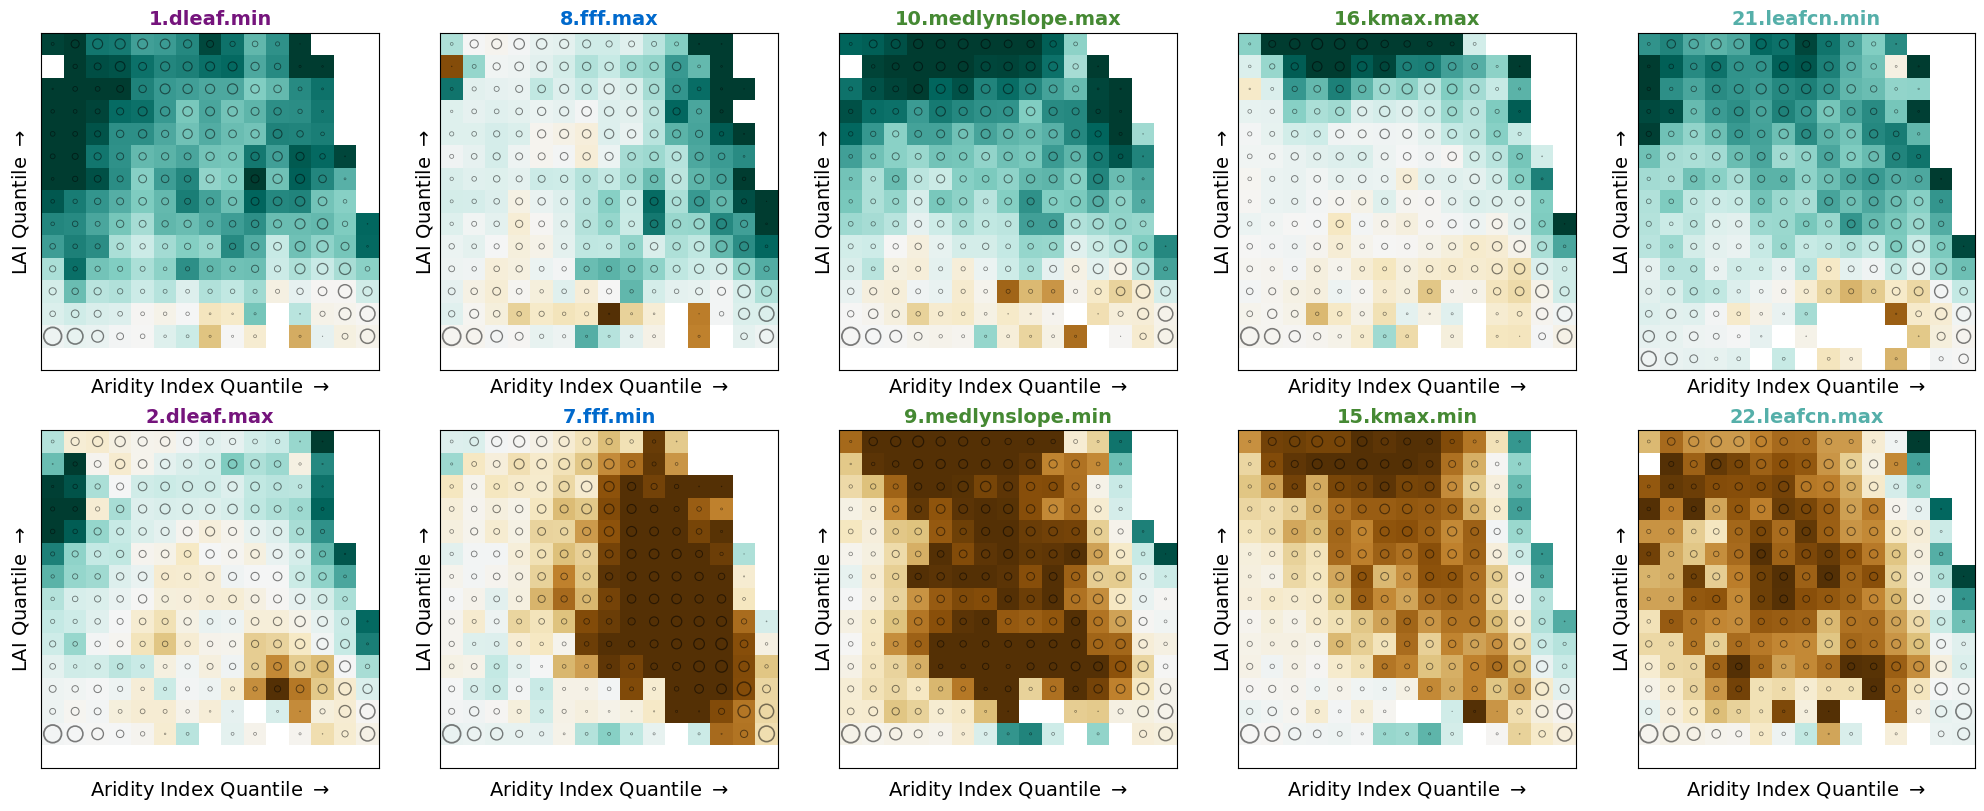

In [ ]:
members = [
    1, 8, 10, 16, 21,
    2, 7, 9, 15, 22,
]
ncols = 5

fig, axs = plot_fhist_binned_mean_multi(
    bs_yr.sel(stats_name="mean"), bs_yr.sel(stats_name="n"), nb, members, "$\\Delta$ET [W m$^{-2}$]", "Aridity Index Quantile", "LAI Quantile",
    cmap="BrBG", vmin=-6, vmax=6, ncols=ncols,
    signif=None, add_circles=True,
)

ax = axs.flatten()
for i in range(len(members)):
    ax[i].tick_params(length=0)
    ax[i].set_xticks(np.arange(15) + 0.5)
    ax[i].set_xticklabels([])
    ax[i].set_yticks(np.arange(15) + 0.5)
    ax[i].set_yticklabels([])
    if i % ncols == 0:
        ax[i].set_ylabel("LAI Quantile $\\rightarrow$", fontsize=14)
    if i // ncols == nrows - 1:
        ax[i].set_xlabel(f"{x_var}", fontsize=12)
    ax[i].set_xlabel("Aridity Index Quantile $\\rightarrow$", fontsize=14)
    ax[i].set_ylabel("LAI Quantile $\\rightarrow$", fontsize=14)

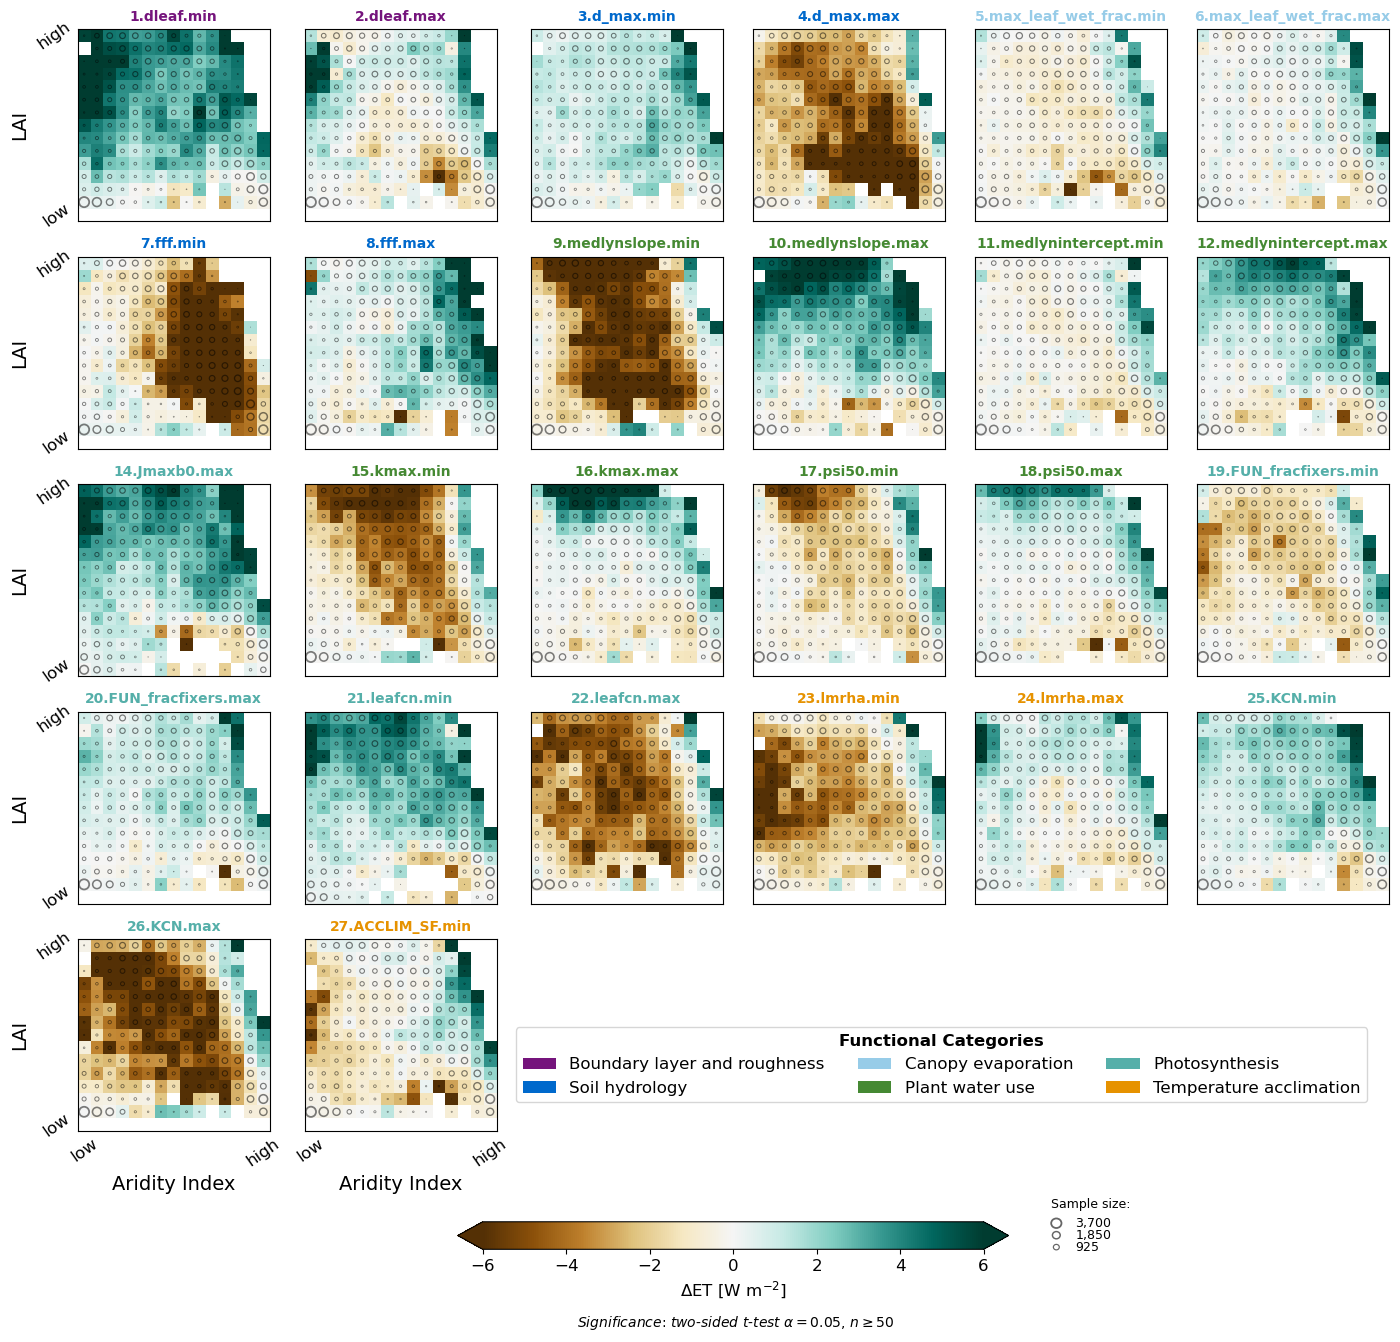

In [279]:
fig, axs = xclim.plot.plot_fhist_binned_mean(
    bs_yr.sel(stats_name="mean"), bs_yr.sel(stats_name="n"), nb, "$\\Delta$ET [W m$^{-2}$]", "Aridity Index", "LAI",
    cmap="BrBG", vmin=-6, vmax=6, signif={"alpha": alpha, "n_min": n_min}, add_circles=True,
)

for i, ax in enumerate(axs.flatten()):
    if i % axs.shape[1] == 0:
        ax.set_ylabel("LAI", fontsize=14)
    if i // axs.shape[1] == axs.shape[0] - 1:
        ax.set_xlabel("Aridity Index", fontsize=14)

z_var = "EFLX_LH_TOT_year_1"
x_var = "AI_clim_1"
y_var = "TLAI_year_1"
fig.savefig(
     f"fig/lmwg/qbin{nb}.{year_start}-{year_end}.TIMEagg.alpha{str(alpha).replace(".", "")}.nmin{n_min}.{x_type}x{x_var}.{y_type}y{y_var}.{z_type}z{z_var}.png",
    bbox_inches='tight', dpi=300,
)

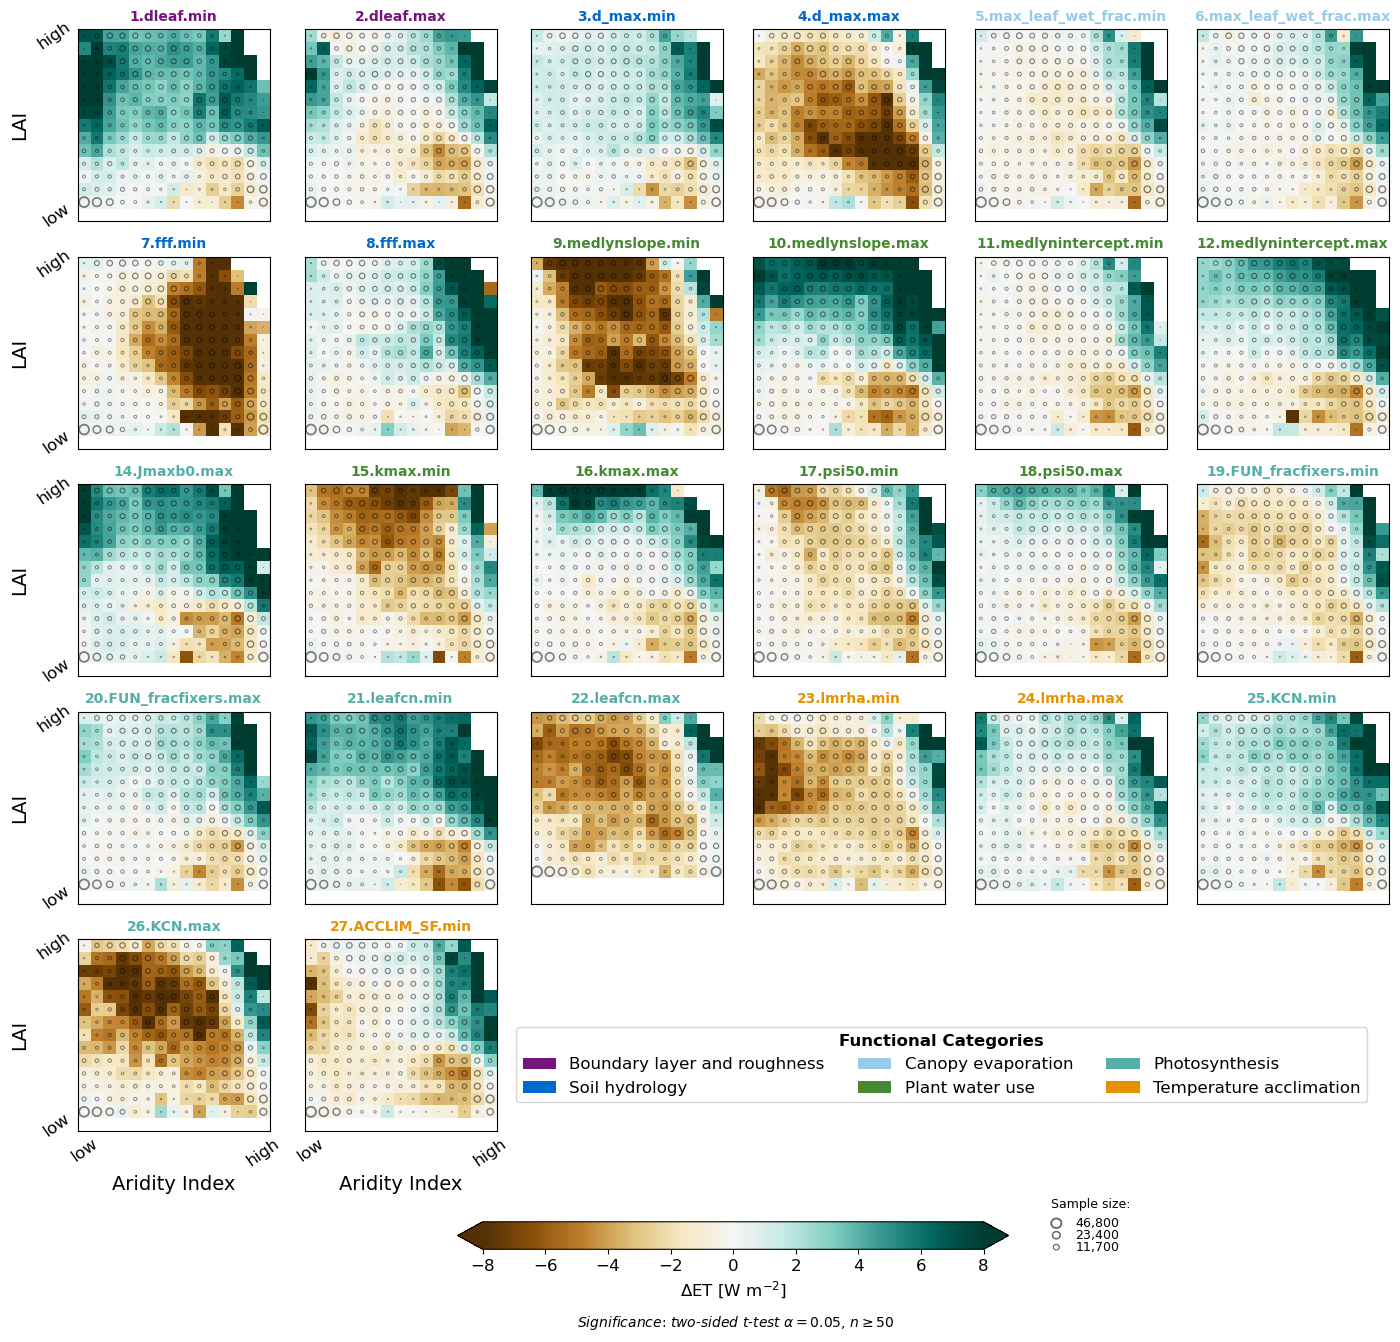

In [280]:
fig, axs = xclim.plot.plot_fhist_binned_mean(
    bs_mn.sel(stats_name="mean"), bs_mn.sel(stats_name="n"), nb, "$\\Delta$ET [W m$^{-2}$]", "Aridity Index", "LAI",
    cmap="BrBG", vmin=-8, vmax=8, signif={"alpha": alpha, "n_min": n_min}, add_circles=True,
)

for i, ax in enumerate(axs.flatten()):
    if i % axs.shape[1] == 0:
        ax.set_ylabel("LAI", fontsize=14)
    if i // axs.shape[1] == axs.shape[0] - 1:
        ax.set_xlabel("Aridity Index", fontsize=14)

z_var = "EFLX_LH_TOT_month_1"
x_var = "AI_clim_1"
y_var = "TLAI_month_1"
fig.savefig(
     f"fig/lmwg/qbin{nb}.{year_start}-{year_end}.TIMEagg.alpha{str(alpha).replace(".", "")}.nmin{n_min}.{x_type}x{x_var}.{y_type}y{y_var}.{z_type}z{z_var}.png",
    bbox_inches='tight', dpi=300,
)